# Initial Value Problems

These examples are based on code originally written by Krzysztof Fidkowski and adapted by Venkat Viswanathan. 

In [1]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

import niceplots

plt.style.use(niceplots.get_style())
colors = niceplots.get_colors_list()

In this example, we will solve an initial value problem using the general scalar diffusion equation:

$$\frac{\partial u}{\partial t} + \frac{\partial}{\partial x}\left(-\nu \frac{\partial}{\partial x} \right) = 0$$

If $\nu$, the diffusion coefficient, is assumed to be constant then we have:

$$\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2}$$

To solve this equation, we will replace **both** the time and space derivatives with finite differences.  We will use a forward difference for the time derivative and a central difference for the space derivative.  The resulting discretization is:

$$\frac{\partial u}{\partial t}(x=x_j, t=t_n) = \left(u_t\right)_j^n = \frac{u_j^{n+1} - u_j^{n}}{\Delta t}$$

$$\frac{\partial^2 u}{\partial x^2}(x=x_j, t=t_n) = \left(u_{xx}\right)_j^n = \frac{u_{j-1}^{n} - 2u_{j}^{n} + u_{j+1}^{n}}{\Delta x^2}$$

Substituting these into the original PDE, and rearranging for the value of $u$ at the next timestep gives:

$$u_j^{n+1} = u_j^{n} + \frac{\nu \Delta t}{\Delta x^2}\left(u_{j-1}^{n} - 2u_{j}^{n} + u_{j+1}^{n}\right)$$

In this example we'll solve the diffusion equation on a 1D domain with a length of 2.
We'll treat the problem as periodic, which means that the left and right boundaries are connected.

findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not f

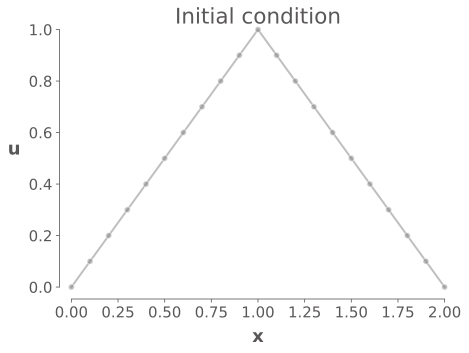

In [2]:
def getInitialCondition(N, L):
    x = jnp.linspace(0, L, N + 1)
    return x, 1 - jnp.abs(x - 1)


Nx = 20
L = 2.0
dx = L / Nx
tFinal = 0.12
nu = 1.0

x, u0 = getInitialCondition(Nx, L)

fig, ax = plt.subplots()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u$", rotation="horizontal", ha="right")
ax.plot(x, u0, "-o", color="gray", alpha=0.5, clip_on=False)
niceplots.adjust_spines(ax)
ax.set_title("Initial condition")
plt.show()

In [3]:
def FTCS_solver(u0, nu, dx, dt, T):
    # Initialize the solution array (ignore the final node since it's a duplicate of the first)
    u = u0.copy()[:-1]

    # Define the number of time steps
    num_steps = int(T / dt)

    # Main time-stepping loop
    for _ in range(num_steps):
        # Compute the spatial derivative (centered in space)
        uxx = (jnp.roll(u, 1) - 2 * u + jnp.roll(u, -1)) / (dx**2)

        # Update the solution using forward time-stepping
        u += nu * uxx * dt

    # Add the final node back in to the state
    u = jnp.append(u, u[0])
    return u


def computeTimestepFromMu(mu, dx, nu):
    return mu * dx**2 / nu


def plotSolution(ax, x, u0, u, tFinal):
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$u$", rotation="horizontal", ha="right")

    if not isinstance(u, list):
        u = [u]
    if not isinstance(tFinal, list):
        tFinal = [tFinal]

    cmap = plt.get_cmap("cool")
    colors = [cmap(i) for i in jnp.linspace(0, 1, len(u))]

    ax.plot(x, u0, "-o", label=r"$t = 0$", color="gray", alpha=0.5, zorder=0, clip_on=False)
    for ii in range(len(u)):
        ax.plot(x, u[ii], "-o", label=f"$t = {tFinal[ii]}$", c=colors[ii], zorder=1, clip_on=False)

    niceplots.adjust_spines(ax, outward=True)
    niceplots.label_line_ends(ax)

findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: 

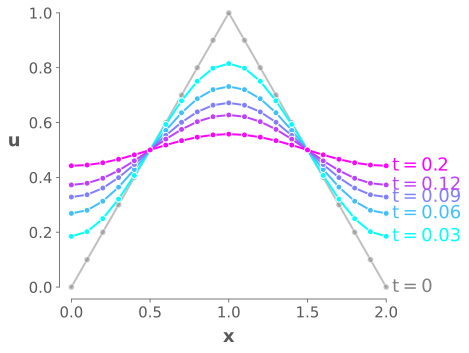

In [4]:
dt = computeTimestepFromMu(0.25, dx, nu)

t = [0.03, 0.06, 0.09, 0.12, 0.2]
u = []
for tFinal in t:
    u.append(FTCS_solver(u0, nu, dx, dt, tFinal))

fig, ax = plt.subplots()
plotSolution(ax, x, u0, u, t)

Now let's try running the same problem with different sizes of timestep.
Before we do, it's useful to define something called the heat number:
$$\mu = \frac{\nu \Delta t}{\Delta x^2}$$

Using this definition, our timestepping equation becomes:

$$u_j^{n+1} = u_j^{n} + \mu\left(u_{j-1}^{n} - 2u_{j}^{n} + u_{j+1}^{n}\right)$$

Using stability analysis methods, that you will learn in this section of the course, we can show that this timestepping scheme is only stable if $\mu \leq \frac{1}{2}$.
The code below demonstrates this by running the same problem as above with $\mu$ values ranging from 0.25 to 0.75

findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: 

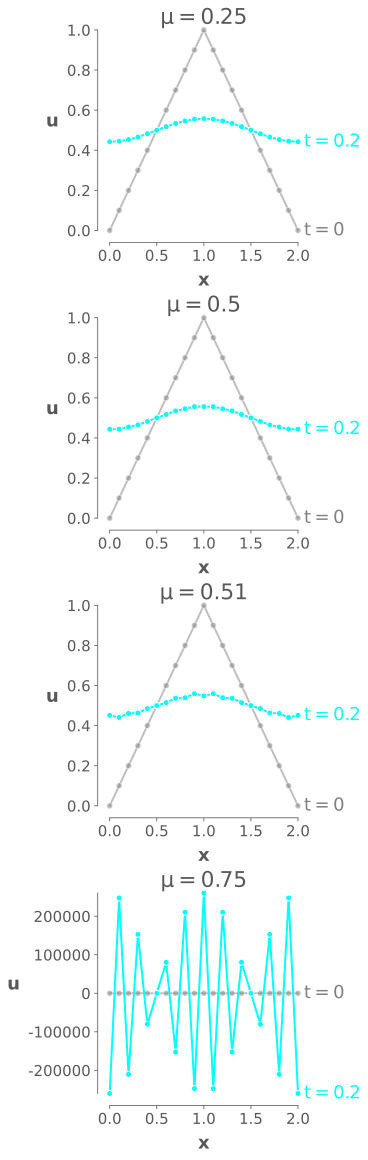

In [5]:
muVals = [0.25, 0.5, 0.51, 0.75]

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(5, 16))

axes = axes.flatten()

for mu, ax in zip(muVals, axes):
    dt = computeTimestepFromMu(mu, dx, nu)
    uFinal = FTCS_solver(u0, nu, dx, dt, tFinal)
    plotSolution(ax, x, u0, uFinal, tFinal)
    ax.set_title(f"$\mu = {mu}$")